# Data Quality Assessment

In [1]:
import warnings
warnings.filterwarnings('ignore')

%config IPCompleter.greedy=True

In [2]:
import pandas as pd

extract = '../01_data/extract_final.csv'
names=['ticket', 'type', 'client', 'issuer', 'inquiry', 'state', 'meta']

corpus = pd.read_csv(extract, sep=',', encoding='ansi', names=names, skiprows=[0])
corpus['ticket'] = corpus['ticket'].astype(str)

corpus.head()

,ticket,type,client,issuer,inquiry,state,meta
0,2019030563000120,Fehler in der App,SVBA,3,Ich kann die Bilder in übungen nicht Bearbeite...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...
1,2019030563000120,Fehler in der App,SVBA,1,Wir haben Ihre Support-Anfrage erhalten besten...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...
2,2019030563000020,Fehler in der App,SVBA,3,Bei mir erscheinen eingefügte Bilder im Fachre...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...
3,2019030563000020,Fehler in der App,SVBA,1,Damit wir das Problem besser eingrenzen können...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...
4,2019030463000110,Fehler in der App,FOMA,1,Besten Dank für Ihre Support-Anfrage. Wir verm...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...


### Umfang der Daten
* 5170 Zeilen
* 1274 Nullwerte
* 114 Duplikate

Am Schluss bleiben: 3752 Zeilen

In [3]:
len(corpus)

5170

#### Nullwerte

In [4]:
len(corpus[corpus['inquiry'].isnull()])

1274

In [5]:
corpus.dropna(axis=0, how='any', inplace=True)
corpus['inquiry'].count()

3866

#### Duplikate und Nullwerte entfernen

In [6]:
corpus['inquiry'] = corpus['inquiry'].str.lower()
corpus.duplicated(subset='inquiry').sum()

114

In [7]:
corpus.drop_duplicates(subset='inquiry', keep='last', inplace=True)
len(corpus)

3752

### Matchen Frage (3) zu Antwort (1) via Ticketnummer
Damit dies funktioniert reduzieren wir den Datensatz weiter. Alle Zeilen bei denen die Ticket Nummer nur einmal vorkommt werden gelöscht.

In [8]:
corpus = corpus[corpus.duplicated(subset='ticket', keep=False)]
len(corpus)

3101

3101 ist eine ungerade Zahl. Heisst *n* Tickets kommen mehr als doppelt vor. Gehen wir das auf den Grund.

In [9]:
corpus['ticket'].describe()

count                 3101
unique                1550
top       2018082963000410
freq                     3
Name: ticket, dtype: object

In [10]:
corpus.loc[corpus['ticket'] == '2018082963000410']

,ticket,type,client,issuer,inquiry,state,meta
1431,2018082963000410,Fehler in der App,VEL,3,"im fachbuch \""fk\"" gehe die seitenlink im sac...",closed successful,App: beook 5.4.3 | Model: 12 cores | Platform:...
1432,2018082963000410,Fehler in der App,VEL,3,wie schon gemeldet habe ich das gleiche proble...,closed successful,App: beook 5.4.3 | Model: 12 cores | Platform:...
1433,2018082963000410,Fehler in der App,VEL,1,guten tag thomas gabathuler besten dank für d...,closed successful,App: beook 5.4.3 | Model: 12 cores | Platform:...


Nun entfernen wir die Zeile mit Index *1432*

In [11]:
corpus.drop([1432], inplace=True)
len(corpus)

3100

In [12]:
corpus['ticket'].describe()

count                 3100
unique                1550
top       2018083063000060
freq                     2
Name: ticket, dtype: object

#### Wieviele davon sind Fragen?

In [13]:
question = 3
answer = 1

corpus.loc[corpus['issuer'] == answer]['issuer'].sum()

1548

In [14]:
corpus.loc[corpus['issuer'] == question]['issuer'].sum() // 3

1552

Sieht so aus als wären 2 Tickets die 2x aus Fragen bestehen. Finden wir sie.

In [15]:
import numpy as np

group_by_ticket = corpus.groupby(['ticket']).apply(lambda t: 'fraud' if t['issuer'].mean() != 2.0 else np.nan)
group_by_ticket.dropna()

ticket
2016120263000050    fraud
2016121263000010    fraud
dtype: object

Üperprüfen wir ob diese zwei Tatsächlich 2x aus Fragen bestehen.

In [16]:
corpus.loc[corpus['ticket'] == '2016120263000050']

,ticket,type,client,issuer,inquiry,state,meta
4334,2016120263000050,Fehler in der App,SVBA,3,freundliche grüsse felix buchenberger berufsfa...,closed successful,App: beook 4.2.0 | Model: 8 cores | Platform: ...
4335,2016120263000050,Fehler in der App,SVBA,3,wollte gerade eben ein hypercam filmli machen ...,closed successful,App: beook 4.2.0 | Model: 8 cores | Platform: ...


In [17]:
corpus.loc[corpus['ticket'] == '2016121263000010']

,ticket,type,client,issuer,inquiry,state,meta
4308,2016121263000010,Fehler in der App,WINGS,3,ich habe gesehen dass ich mitglied dieser grup...,closed successful,App: beook 4.2.3 | Model: 4 cores | Platform: ...
4309,2016121263000010,Fehler in der App,WINGS,3,ich habe gestern auf meinem windows pc zu haus...,closed successful,App: beook 4.2.3 | Model: 4 cores | Platform: ...


In [18]:
corpus.drop([4308, 4309], inplace=True)
corpus.drop([4334, 4335], inplace=True)
len(corpus)

3096

#### Fragen und Antworten zusammenfügen

In [19]:
corpus.sort_values(by=['ticket', 'issuer'], ascending=['True', 'True'], inplace=True)
q_and_a_corpus = corpus.loc[corpus['issuer'] == 3]
len(q_and_a_corpus)

1548

In [20]:
q_and_a_corpus['answer'] = corpus.loc[corpus['issuer'] == 1]['inquiry'].values
q_and_a_corpus.head()

,ticket,type,client,issuer,inquiry,state,meta,answer
5168,2015081263000080,Fehler in der App,hep,3,habe soeben gesb ah gelöscht und danach die ap...,closed successful,User account exists: Yes | | App: eLehrmittel ...,danke habe es korrigiert. war ein seltener fa...
5166,2015081763000050,Anmeldung / Aktivierung,AppInbox,3,das elehrmittel funktioniert auf meinem gerät ...,closed successful,App: eLehrmittel 3.0.9 | Model: 4 cores | Plat...,guten tag herr hirsiger können sie uns bitte m...
5164,2015081763000060,Anmeldung / Aktivierung,AppInbox,3,falls sie ein problem mit der anmeldung oder d...,closed successful,App: eLehrmittel 3.0.9 | Model: 4 cores | Plat...,guten tag herr rados haben sie probleme mit un...
5162,2015081763000110,Anmeldung / Aktivierung,AppInbox,3,als ich die software gestartet habe funktionie...,closed successful,App: eLehrmittel 3.0.9 | Model: 4 cores | Plat...,guten tag schlatter yassin bitte beschreiben s...
5160,2015082463000180,Anmeldung / Aktivierung,Swissmem,3,falls sie ein problem mit der anmeldung oder d...,closed successful,App: Swissmem eBOOK 3.2.1 | Model: 4 cores | P...,hallo marcel besten dank für deinen bericht. d...


Überprüfen wir das kurz

In [21]:
tickets = ['2015081263000080', '2015081763000050', '2015081763000060', '2015081763000110', '2015082463000180']
for t in tickets:
    print(corpus.loc[corpus['ticket'] == t].inquiry, '\n')

5167     danke habe es korrigiert. war ein seltener fa...
5168    habe soeben gesb ah gelöscht und danach die ap...
Name: inquiry, dtype: object 

5165    guten tag herr hirsiger können sie uns bitte m...
5166    das elehrmittel funktioniert auf meinem gerät ...
Name: inquiry, dtype: object 

5163    guten tag herr rados haben sie probleme mit un...
5164    falls sie ein problem mit der anmeldung oder d...
Name: inquiry, dtype: object 

5161    guten tag schlatter yassin bitte beschreiben s...
5162    als ich die software gestartet habe funktionie...
Name: inquiry, dtype: object 

5159    hallo marcel besten dank für deinen bericht. d...
5160    falls sie ein problem mit der anmeldung oder d...
Name: inquiry, dtype: object 



sehr gut das matching hat funktioniert.

#### export to csv

In [22]:
q_and_a_corpus.to_csv(r'../01_data/ionesoft_extract_final_clean.csv', index=None, header=True)

### Antwort zu Kategorie
Nun müssen die Antworten einer Kategorie zugeorndet werden.

In [23]:
template = '../01_data/standard_template.csv'
names=['name', 'text']

template_corpus = pd.read_csv(template, sep=';', encoding='ansi', names=names, skiprows=[0])

template_corpus.head()

,name,text
0,"Abmelden, neu anmelden",Sie sind aktuell nicht mehr korrekt in der App...
1,"Abmelden, neu anmelden (FR)",Vous n'êtes actuellement plus correctement con...
2,Aktivierungscode falsch,Wir können leider keinen Aktivierungscode im S...
3,"Altes Ticket, Problem gelöst?","Wir haben festgestellt, dass Sie noch ein offe..."
4,"Anderer Anbieter, falsches Login",Sie sind beim falschen Anbieter angemeldet!<br...


#### FR, IT entfernen

In [24]:
template_corpus = template_corpus.loc[template_corpus['name'].str.contains('\(FR\)', case=False, regex=True) == False]
template_corpus = template_corpus.loc[template_corpus['name'].str.contains('FR', case=False, regex=True) == False]
template_corpus = template_corpus.loc[template_corpus['name'].str.contains('\(IT\)', case=False, regex=True) == False]

template_corpus.head()

,name,text
0,"Abmelden, neu anmelden",Sie sind aktuell nicht mehr korrekt in der App...
2,Aktivierungscode falsch,Wir können leider keinen Aktivierungscode im S...
3,"Altes Ticket, Problem gelöst?","Wir haben festgestellt, dass Sie noch ein offe..."
4,"Anderer Anbieter, falsches Login",Sie sind beim falschen Anbieter angemeldet!<br...
5,Android: alte beook version -> updaten!,Vielen Dank für ihre Support-Anfrage.<br />Ihr...


Annahme enthält die Antwort _abmelden_ oder _anmelden_ handelt es sich um ein _Abmelden, neu anmelden_ Problem

In [25]:
import re

def to_regex_expr(text):
    text = text.lower()
    text = re.sub(r'[^\u00C0-\u017Fa-zA-Z\s]', ' ', text, re.I | re.A)
    text.replace('  ', ' ')
    text = [w for w in text.split(' ')]
    return text


template_corpus['expr'] = template_corpus['text'].apply(lambda x: to_regex_expr(x))
template_corpus.head()

,name,text,expr
0,"Abmelden, neu anmelden",Sie sind aktuell nicht mehr korrekt in der App...,"[sie, sind, aktuell, nicht, mehr, korrekt, in,..."
2,Aktivierungscode falsch,Wir können leider keinen Aktivierungscode im S...,"[wir, können, leider, keinen, aktivierungscode..."
3,"Altes Ticket, Problem gelöst?","Wir haben festgestellt, dass Sie noch ein offe...","[wir, haben, festgestellt, , dass, sie, noch, ..."
4,"Anderer Anbieter, falsches Login",Sie sind beim falschen Anbieter angemeldet!<br...,"[sie, sind, beim, falschen, anbieter, angemeld..."
5,Android: alte beook version -> updaten!,Vielen Dank für ihre Support-Anfrage.<br />Ihr...,"[vielen, dank, für, ihre, support, anfrage, , ..."


In [26]:
from nltk import FreqDist

expr = [item for sublist in template_corpus['expr'].values.tolist() for item in sublist]

fdist1 = FreqDist(expr)
fdist1

FreqDist({'': 5743, 'sie': 891, 'br': 807, 'li': 398, 'die': 393, 'der': 350, 'und': 234, 'app': 231, 'in': 219, 'können': 205, ...})

In [27]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]

fdist1.plot(50, cumulative=False)

<Figure size 1000x1000 with 1 Axes>

#### Expr aktualisieren, damit nur Einzigartige expr vorhanden sind

In [28]:
whitelist = fdist1.hapaxes()

In [29]:
def only_unique(expr):
    return str.join(' | ', [e for e in expr if e in whitelist])

template_corpus['expr'] = template_corpus['expr'].apply(lambda x: only_unique(x))

template_corpus.head()

,name,text,expr
0,"Abmelden, neu anmelden",Sie sind aktuell nicht mehr korrekt in der App...,
2,Aktivierungscode falsch,Wir können leider keinen Aktivierungscode im S...,genannten | entspricht | abgedruckt | beachtun...
3,"Altes Ticket, Problem gelöst?","Wir haben festgestellt, dass Sie noch ein offe...",offenes | aufgetreten
4,"Anderer Anbieter, falsches Login",Sie sind beim falschen Anbieter angemeldet!<br...,anderem | button | startseite
5,Android: alte beook version -> updaten!,Vielen Dank für ihre Support-Anfrage.<br />Ihr...,


#### Kategorisieren

In [30]:
def search_and_replace(expr, category):
    if len(expr) > 0:
        q_and_a_corpus.loc[
            q_and_a_corpus['answer'].str.contains(expr, case=True, regex=True) == True,
            'answer'
        ] = category

for row in template_corpus.itertuples(index=True, name='Pandas'):
    search_and_replace(getattr(row, 'expr'), getattr(row, 'name'))

In [31]:
q_and_a_corpus.head()

,ticket,type,client,issuer,inquiry,state,meta,answer
5168,2015081263000080,Fehler in der App,hep,3,habe soeben gesb ah gelöscht und danach die ap...,closed successful,User account exists: Yes | | App: eLehrmittel ...,Workspace in Dropbox kopieren für Support
5166,2015081763000050,Anmeldung / Aktivierung,AppInbox,3,das elehrmittel funktioniert auf meinem gerät ...,closed successful,App: eLehrmittel 3.0.9 | Model: 4 cores | Plat...,beook Cloud synchronisieren
5164,2015081763000060,Anmeldung / Aktivierung,AppInbox,3,falls sie ein problem mit der anmeldung oder d...,closed successful,App: eLehrmittel 3.0.9 | Model: 4 cores | Plat...,guten tag herr rados haben sie probleme mit un...
5162,2015081763000110,Anmeldung / Aktivierung,AppInbox,3,als ich die software gestartet habe funktionie...,closed successful,App: eLehrmittel 3.0.9 | Model: 4 cores | Plat...,RCP: Dropbox - ebookAktualisierung - Datenverlust
5160,2015082463000180,Anmeldung / Aktivierung,Swissmem,3,falls sie ein problem mit der anmeldung oder d...,closed successful,App: Swissmem eBOOK 3.2.1 | Model: 4 cores | P...,Anmeldung mit falscher E-Mail


In [32]:
max_category_length = template_corpus['name'].str.len().max()
max_category_length

67

#### folgende Antworten wurden nicht Kategorisiert

In [33]:
q_and_a_corpus.loc[q_and_a_corpus['answer'].str.len() > max_category_length]

,ticket,type,client,issuer,inquiry,state,meta,answer
5164,2015081763000060,Anmeldung / Aktivierung,AppInbox,3,falls sie ein problem mit der anmeldung oder d...,closed successful,App: eLehrmittel 3.0.9 | Model: 4 cores | Plat...,guten tag herr rados haben sie probleme mit un...
4885,2016031463000060,Anmeldung / Aktivierung,Swissmem,3,wir setzen an der berufsfachschule für alle le...,closed successful,App: Swissmem eBOOK 3.5.0 | Model: 4 cores | P...,schulung c. grob und a. rushiti am 15.03.16. d...
3469,2017080963000040,Fehler in der App,VSRT-BBZ,3,lernende aller klassen können sich nicht zum e...,closed_waiting_for_reply,App: beook 4.6.1 | Model: 4 cores | Platform: ...,gelöst durch christian schlatter ionesoft. zuv...
2749,2017112763000030,Geräteanzahl überschritten,SVBA,3,j‘ai changer mon ipad merci de supprimer cet i...,closed_max_devices,User account exists: Yes | | App: beook v5.0.4...,nous avons supprimé tous vos appareils sur l...
2394,2018020263000010,Anmeldung / Aktivierung,hep,3,der couponcode wird als ungültig angegeben leh...,closed_app_misuse,App: eLehrmittel 4.6.2 | Model: 4 cores | Plat...,vielen dank für ihre support-anfrage. sie habe...
1808,2018060763000120,Fehler in der App,BEOOK,3,mit grp verbunden administrator hat angenommen...,closed_app_misuse,App: beook 5.2.4 | Model: 4 cores | Platform: ...,daher wurde dieses ticket geschlossen. es stel...
1606,2018081463000170,Anmeldung / Aktivierung,hep,3,ich kann meine codes nicht einlösen. codes 25f...,closed_license_error,User account exists: Yes | | App: eLehrmittel ...,besten dank für ihre support-anfrage. uns is...
1113,2018092363000020,Anmeldung / Aktivierung,Swissmem,3,bei der registrierung ist etwas falsch gelauf...,closed successful,App: Swissmem eBOOK 5.4.6 | Model: 4 cores | P...,sehr geehrter herr zimmermann die mailadresse ...
759,2018110763000080,Anmeldung / Aktivierung,hep,3,falls sie ein problem mit der anmeldung oder d...,closed_waiting_for_reply,App: eLehrmittel 5.4.6 | Model: 4 cores | Plat...,die kundin hat bereits eine support-anfrage ge...


#### Export nur Kategorisierte Zeilen

In [34]:
valid_values = template_corpus['name'].values.tolist()
q_and_a_corpus = q_and_a_corpus.loc[q_and_a_corpus['answer'].isin(valid_values)]

In [35]:
q_and_a_corpus.to_csv(r'../01_data/ionesoft_extract_final_categorised.csv', index=None, header=True)

### Verteilung von Fragen auf Antwort Kategorien

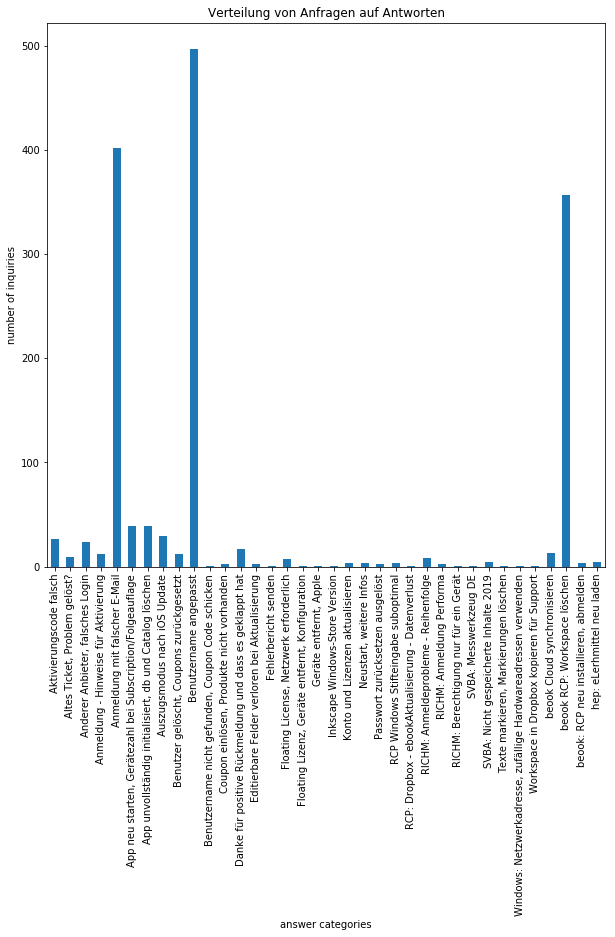

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure(figsize=(10, 10))

q_and_a_corpus.groupby('answer').inquiry.count().plot.bar(ylim=0)
plt.title('Verteilung von Anfragen auf Antworten')
plt.xlabel('answer categories')
plt.ylabel('number of inquiries')
plt.show()